# Implementacja i testy datasetu MIT-BIH_Arrythmia

In [27]:
import os
import pandas as pd
from torchvision.io import read_image
import re
import wfdb
import wfdb.processing
import scipy
from torch.utils.data import Dataset
import numpy as np
import json

def extract_segment_with_padding(z, k, N):
    # Rozmiar segmentu to 2N + 1
    start_idx = k - N
    end_idx = k + N + 1  # Indeks końcowy +1, ponieważ Python używa wykluczającego indeksu
    
    # Upewnij się, że start_idx i end_idx mieszczą się w granicach tablicy
    if start_idx < 0:
        # Jeśli start_idx jest poza zakresem, dopełnij na początku
        padding_left = np.median(z[:end_idx])  # Wypełniamy medianą
        segment = np.concatenate([np.full(-start_idx, padding_left), z[:end_idx]])
    elif end_idx > len(z):
        # Jeśli end_idx jest poza zakresem, dopełnij na końcu
        padding_right = np.median(z[start_idx:])  # Wypełniamy medianą
        segment = np.concatenate([z[start_idx:], np.full(end_idx - len(z), padding_right)])
    else:
        # Normalny przypadek, kiedy zakres mieści się w tablicy
        segment = z[start_idx:end_idx]
    
    return segment

def find_nearest_qrs_index(annotation_sample, qrs_inds):
    # Find the index in qrs_inds that is closest to annotation_sample
    distances = np.abs(qrs_inds - annotation_sample)
    nearest_idx = np.argmin(distances)  # Get the index of the minimum distance
    return qrs_inds[nearest_idx]

class MIT_BIH_Arythmia(Dataset):
    def __init__(self,N, M, dataset_dir = 'Datasets/files/', fs = 10, filename = "MIT-BIH_Arrythmia.json"):
        """
        n - number of samples of orginal signal resampled to fs, interval [-n,n]
        m - qrs times, interval [-m,m]
        """
        ecg_list = []
        exclusion_lst = ["00735", "03665", "04043", "04936", "05091", "06453", "08378", "08405", "08434", "08455"]
        for file in os.listdir(dataset_dir):
            name = re.match(r'^(.*)\.atr$', file)
            if name:
                if name.group(1) in exclusion_lst:
                    continue
            if name:
                record = wfdb.rdsamp(f"Datasets/files/{name.group(1)}") 
                annotation = wfdb.rdann(f"Datasets/files/{name.group(1)}", 'atr')
                signal = record[0][:,0]
                fs_original = record[1]["fs"]
                num_samples_target = int(signal.shape[0] * fs / fs_original)
                resampled_signal = scipy.signal.resample(signal, num_samples_target)
                annotation_times_resampled = (annotation.sample * fs) / fs_original
                resampled_annotation = wfdb.Annotation('atr',annotation.symbol,annotation_times_resampled.astype(int),aux_note=annotation.aux_note)
                ecg_list.append({"name": name.group(1),"rec" : resampled_signal, "ann" : resampled_annotation})
        self.samples_list = []
        self.label_list = []
        self.qrs_samples = []
        for dic in ecg_list:
            print(dic["name"])
            # xqrs = wfdb.processing.XQRS(sig=dic["rec"], fs=fs)
            # xqrs.detect()
            # qrs_inds = xqrs.qrs_inds
            for n,i in enumerate(dic["ann"].sample):
                self.label_list.append(1 if dic["ann"].aux_note[n] == '(AFIB' else 0)
                self.samples_list.append(list(extract_segment_with_padding(dic["rec"], dic["ann"].sample[n],N)))
                # nearest_qrs_idx = find_nearest_qrs_index(dic["ann"].sample[n], qrs_inds)
                # self.qrs_samples.append(list(extract_segment_with_padding(qrs_inds,nearest_qrs_idx,M)))
        data = {
            'samples_list': self.samples_list,  # This would work if the segments are simple numeric lists
            'label_list': self.label_list,
            'qrs_samples': self.qrs_samples
        }
        with open(filename, 'w') as f:
            json.dump(data, f)
                
    def __len__(self):
        return len(self.label_list)

    def __getitem__(self, idx):
        return self.samples_list[idx], self.label_list[idx]

In [28]:
ds = MIT_BIH_Arythmia(200,5,fs=100)

04015
04048
04126
04746
04908
05121
05261
06426
06995
07162
07859
07879
07910
08215
08219


In [29]:
print(len(ds))

304


In [30]:
acc = 0
for _,label in ds:
    acc+=label

print(acc)

147


In [32]:
print(ds[4])

([0.13673755513127978, 0.11501946728030124, 0.1685902666656523, 0.19411247309139798, 0.4056706983974825, 0.9972879011289217, 1.4408509031995205, 0.2063113397098375, -1.0628857249577355, -0.8635330617196435, -0.3660359128511219, 0.016478777026724515, 0.03858946545263141, 0.06999943047363509, 0.03660932039028355, 0.08354613627849931, 0.07746656178682208, 0.05830407930963264, 0.012467172880584545, 0.013500454916403393, -0.00922486279048738, -0.02327463915913458, -0.1479843288496901, -0.29278662891112905, -0.38234320278189754, -0.4318195268952414, -0.5428445730476803, -0.621760141691287, -0.7023874119665132, -0.7219343409005985, -0.7085900630581621, -0.6939658647590581, -0.6255289133328414, -0.5218339212890989, -0.3933809145999859, -0.2891510184933345, -0.21794690555421026, -0.13594551743223268, -0.07771736577064366, -0.009039457286770195, 0.04763067648924831, 0.0588896842152678, 0.038295381096183384, -0.033875810693607726, -0.04150945972078745, -0.11567253237581028, -0.1230143783694152, -

Text(0.5, 1.0, 'Signal of: Artial fibliration')

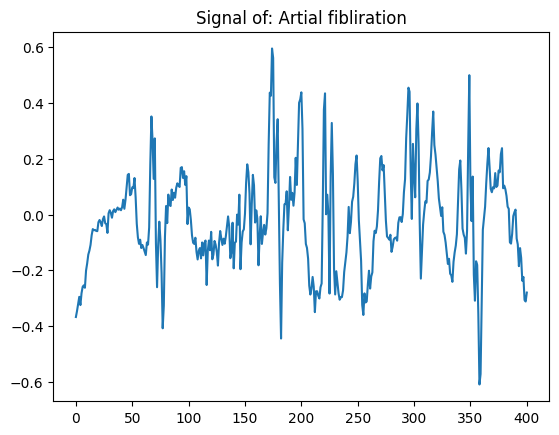

In [35]:
import matplotlib.pyplot as plt
samples, label = ds[167]
plt.plot(samples)
plt.title(f"Signal of: {'Artial fibliration' if label else 'Normal'}")